# Los Angeles city settlements analysis

By [Ben Welsh](http://palewi.re/who-is-ben-welsh/)

This analysis of legal payouts by Los Angeles city government was conducted for the June 25, 2018, _Los Angeles Times_ story ["TK"]().

The Times analyzed a city database listing more than 18,000 payouts dating back to July 2005, obtained through a public records request.

Last budget year, the city paid out more than $200 million in legal settlements and court judgments — a record amount that was more than the city spent on its libraries or fixing its streets. The annual total is expected to drop sharply in the budget year that ends Saturday, but remains much higher than just a few years ago.

Thousands of legal battles involving the Los Angeles Police Department, including a rash of recent settlements over police shootings and wrongful imprisonment, have added up to more than 40% of the total — a higher sum than any other city department. Lawsuits tied to the city departments that oversee its streets and sidewalks, including the Bureau of Street Services and the Department of Transportation, accounted for a growing share. Legal payouts for “dangerous conditions” have rivaled and, last budget year, even exceeded the cost of lawsuits over police misconduct. 

Mayor Eric Garcetti and City Attorney Mike Feuer stressed that the surge is tied to a few cases with extraordinarily large payouts. Beyond the mammoth cases, a pileup of other large payouts has padded the tab. While the total number of payouts has dipped over time, the average amount has increased. Last budget year, the city paid out 30 settlements of $1 million or more — five times as many as a decade before.

The data and computer code that generated those conclusions is below. For more context and reporting on the topic, [read full story at latimes.com]().

## Configuration

Import Python tools

In [102]:
import os
import cpi
import pandas as pd
import altair as alt

Configure pandas

In [103]:
pd.options.display.float_format = '{:,.2f}'.format

Set input and ouput directories

In [104]:
input_dir = os.path.join(os.getcwd(), "input")
output_dir = os.path.join(os.getcwd(), "output")

## Preparation

### Read in the raw data

A list of all legal payouts made by Los Angeles city government was obtained from the office of City Attorney Mike Feuer via a request under the California Public Records Act. The data covering the most recent fiscal year is incomplete. Its totals were gathered elsewhere by interviewing city officials.

In [105]:
raw_df = pd.read_excel(
    os.path.join(input_dir, "payouts.xlsx"),
    skiprows=1,
    skipfooter=2,
    dtype={"FISCAL YEAR": int}
)

### Clean it up

Rename the columns using our crosswalk, developed after interviewing staff at the City Attorney's office on how to properly interpet the fields.

In [106]:
columns = {
    "FISCAL YEAR": "fiscal_year",
    "CASE NAME": "name",
    "CLAIM # / CASE #": "number",
    "AMOUNT": "amount",
    "DEPARTMENT": "department", 
    "CASE TYPE": "type"
}

In [107]:
df = raw_df.rename(columns=columns)

Strip whitespace

In [108]:
df['name'] = df.name.str.strip()
df['number'] = df.number.str.strip()
df['department'] = df.department.str.strip().str.upper()
df['type'] = df.type.str.strip()

Standardize the many variations in the `type` field using a custom crosswalk. Our classifications were submitted to officials at the City Attorney's office for review. They offered no corrections or comment.

In [109]:
case_types = pd.read_csv(os.path.join(input_dir, "casetypes.csv"))

In [110]:
df = df.merge(case_types, on="type", how="inner")

Standardize the variations on the city department names.

In [111]:
departments = pd.read_csv(os.path.join(input_dir, "departments.csv"))

In [112]:
df = df.merge(departments, on="department", how="inner")

Verify the row count is unchanged after the joining the crosswalks

In [113]:
assert len(raw_df) == len(df)

## Analysis

### What is the total number of payouts?

In [114]:
len(df)

18701

### In total, how much money has been paid out?

In [115]:
"${:,.0f}".format(df.amount.sum())

'$880,687,820'

### What are the other descriptive statistics?

In [116]:
df.amount.describe().reset_index()

,index,amount
0,count,"18,701.00"
1,mean,"47,093.09"
2,std,"556,335.14"
3,min,"-1,500,000.00"
4,25%,600.00
5,50%,"1,917.00"
6,75%,"6,300.00"
7,max,"45,789,960.62"


### How many payouts have been made each year?

In [117]:
annual_totals = df.groupby("fiscal_year").agg(dict(
    amount="sum",
    number="count"
)).reset_index().set_index("fiscal_year")

In [118]:
annual_totals['average'] = annual_totals.apply(lambda x: x['amount'] / float(x['number']), axis=1)

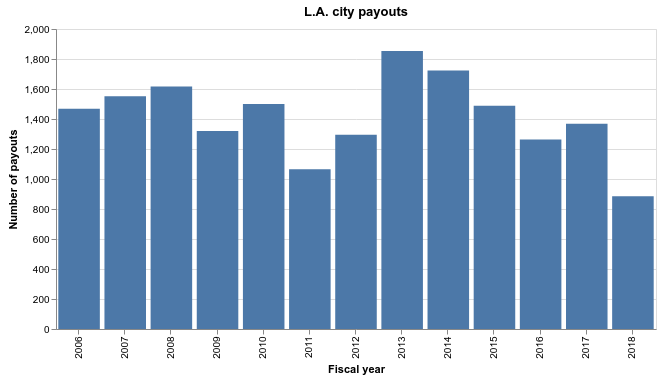

In [119]:
alt.Chart(annual_totals.reset_index(), title="L.A. city payouts").mark_bar().encode(
    x=alt.X("fiscal_year:O", axis=alt.Axis(title="Fiscal year")),
    y=alt.Y("number:Q", axis=alt.Axis(title="Number of payouts")),
).properties(width=600)

In [120]:
annual_totals.number.describe().reset_index()

,index,number
0,count,13.00
1,mean,"1,415.23"
2,std,260.38
3,min,885.00
4,25%,"1,295.00"
5,50%,"1,468.00"
6,75%,"1,551.00"
7,max,"1,854.00"


In [121]:
annual_totals[['number']]

,number
fiscal_year,
2006,1468
2007,1551
2008,1616
2009,1320
2010,1500
2011,1065
2012,1295
2013,1854
2014,1723


### What is the annual cost?

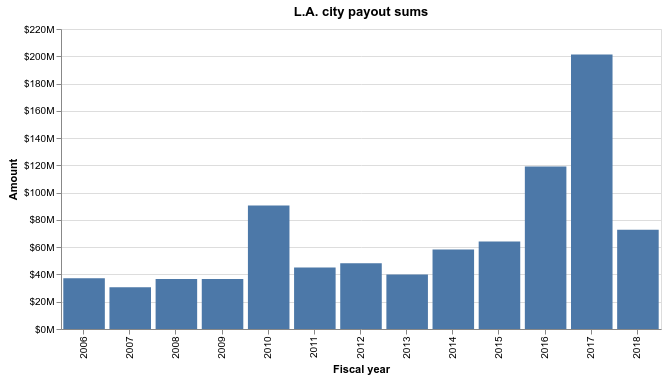

In [122]:
alt.Chart(annual_totals.reset_index(), title="L.A. city payout sums").mark_bar().encode(
    x=alt.X("fiscal_year:O", axis=alt.Axis(title="Fiscal year")),
    y=alt.Y("amount:Q", axis=alt.Axis(title="Amount", format="$s")),
).properties(width=600)

In [123]:
annual_totals.amount.describe().reset_index()

,index,amount
0,count,13.00
1,mean,"67,745,216.90"
2,std,"47,480,404.12"
3,min,"30,593,290.00"
4,25%,"37,206,924.00"
5,50%,"48,298,045.00"
6,75%,"72,829,596.81"
7,max,"201,372,336.23"


In [124]:
annual_totals[['amount']]

,amount
fiscal_year,
2006,"37,206,924.00"
2007,"30,593,290.00"
2008,"36,637,836.00"
2009,"36,750,732.00"
2010,"90,536,467.00"
2011,"45,016,329.00"
2012,"48,298,045.00"
2013,"39,897,408.05"
2014,"58,345,556.09"


### How has the average payout size changed?

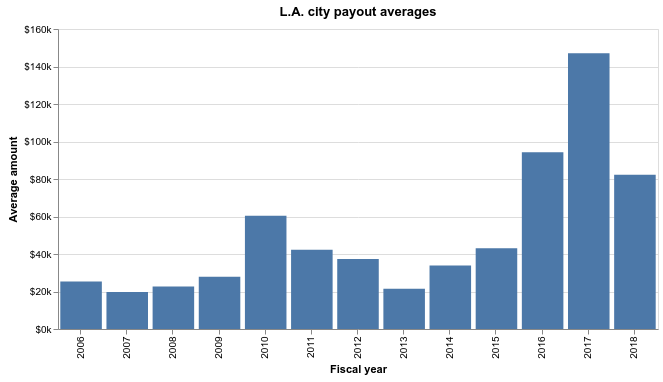

In [125]:
alt.Chart(annual_totals.reset_index(), title="L.A. city payout averages").mark_bar().encode(
    x=alt.X("fiscal_year:O", axis=alt.Axis(title="Fiscal year")),
    y=alt.Y("average:Q", axis=alt.Axis(title="Average amount", format="$s")),
).properties(width=600)

In [126]:
annual_totals[['average']]

,average
fiscal_year,
2006,"25,345.32"
2007,"19,724.88"
2008,"22,671.93"
2009,"27,841.46"
2010,"60,357.64"
2011,"42,268.85"
2012,"37,295.79"
2013,"21,519.64"
2014,"33,862.77"


### How does the peak year compare to a decade before?

In [127]:
"The peak year was {:.1f} times more than a decade before.".format(
    annual_totals.at[2017, "amount"] / annual_totals.at[2007, "amount"]
)

'The peak year was 6.6 times more than a decade before.'

### What departments account for the most payouts?

In [128]:
dept_totals = df.groupby("latimes_department").agg(dict(
    number="count",
    amount="sum"
)).reset_index().set_index("latimes_department").sort_values(
    "amount",
    ascending=False
)

In [129]:
dept_totals['number_percent'] = dept_totals.number / len(df)
dept_totals['amount_percent'] = dept_totals.amount / df.amount.sum()

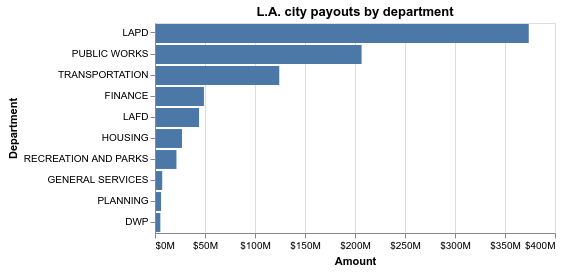

In [130]:
alt.Chart(dept_totals.reset_index().head(10), title="L.A. city payouts by department").mark_bar().encode(
    x=alt.X("amount:Q", axis=alt.Axis(title="Amount", format="$s")),
    y=alt.Y(
        "latimes_department:N",
        sort=alt.SortField(field="amount", op="sum", order="descending"),
        axis=alt.Axis(title="Department")
    )
)

In [131]:
dept_totals.head(10)

,amount,number,number_percent,amount_percent
latimes_department,,,,
LAPD,"373,751,894.14",3824,0.20,0.42
PUBLIC WORKS,"206,591,227.33",11032,0.59,0.23
TRANSPORTATION,"124,254,979.89",992,0.05,0.14
FINANCE,"48,946,060.83",19,0.00,0.06
LAFD,"44,034,102.46",782,0.04,0.05
HOUSING,"27,018,440.63",33,0.00,0.03
RECREATION AND PARKS,"21,446,942.95",787,0.04,0.02
GENERAL SERVICES,"7,209,380.11",375,0.02,0.01
PLANNING,"6,056,337.35",43,0.00,0.01


Write out a CSV for a graphic

In [132]:
dept_totals.to_csv(os.path.join(output_dir, "department-totals.csv"))

### What have the trends been for the top departments?

In [133]:
top_dept_df = df[df.latimes_department.isin(['LAPD', 'PUBLIC WORKS', 'TRANSPORTATION'])]

In [134]:
top_dept_annual_totals = top_dept_df.groupby(["fiscal_year", 'latimes_department']).agg(dict(
    amount="sum",
)).reset_index()

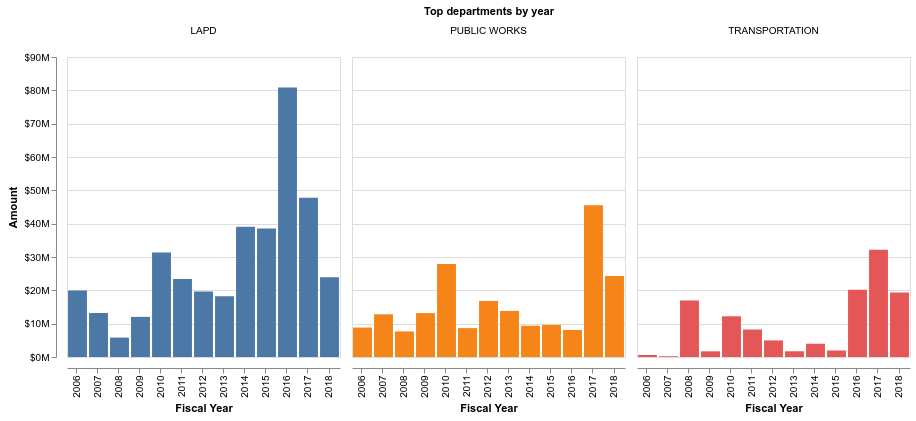

In [135]:
alt.Chart(top_dept_annual_totals).mark_bar().encode(
    x=alt.X("fiscal_year:O", axis=alt.Axis(title="Fiscal Year")),
    y=alt.Y("amount:Q", axis=alt.Axis(title="Amount", format="$s")),
    color=alt.Color("latimes_department:N", legend=None),
    column=alt.Column("latimes_department:N", title="Top departments by year"),
)

### What case types account for the most payouts?

In [136]:
type_totals = df.groupby("latimes_type").agg(dict(
    number="count",
    amount="sum"
)).reset_index().set_index("latimes_type").sort_values(
    "amount",
    ascending=False
)

In [137]:
type_totals['number_percent'] = type_totals.number / len(df)
type_totals['amount_percent'] = type_totals.amount / df.amount.sum()

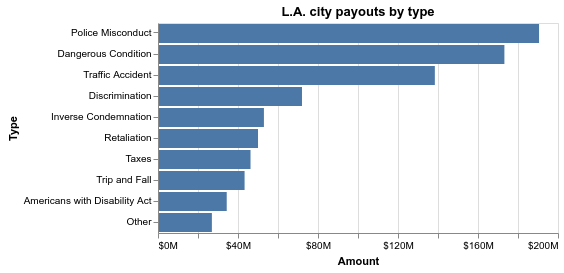

In [138]:
alt.Chart(type_totals.reset_index().head(10), title="L.A. city payouts by type").mark_bar().encode(
    x=alt.X("amount:Q", axis=alt.Axis(title="Amount", format="$s")),
    y=alt.Y(
        "latimes_type:N",
        sort=alt.SortField(field="amount", op="sum", order="descending"),
        axis=alt.Axis(title="Type")
    )
)

In [139]:
type_totals.head(10)

,amount,number,number_percent,amount_percent
latimes_type,,,,
Police Misconduct,"190,525,995.21",457,0.02,0.22
Dangerous Condition,"173,189,941.24",4647,0.25,0.20
Traffic Accident,"138,422,936.03",9466,0.51,0.16
Discrimination,"71,993,217.34",199,0.01,0.08
Inverse Condemnation,"52,959,034.57",95,0.01,0.06
Retaliation,"50,007,623.33",89,0.00,0.06
Taxes,"46,260,855.83",4,0.00,0.05
Trip and Fall,"43,291,261.18",1764,0.09,0.05
Americans with Disability Act,"34,361,805.96",11,0.00,0.04


In [140]:
type_totals.to_csv(os.path.join(output_dir, "type-totals.csv"))

### What have the trends been for the top types?

In [141]:
top_type_df = df[df.latimes_type.isin(['Police Misconduct', 'Dangerous Condition', 'Traffic Accident'])]

In [142]:
top_type_annual_totals = top_type_df.groupby(["fiscal_year", 'latimes_type']).agg(dict(
    amount="sum",
)).reset_index()

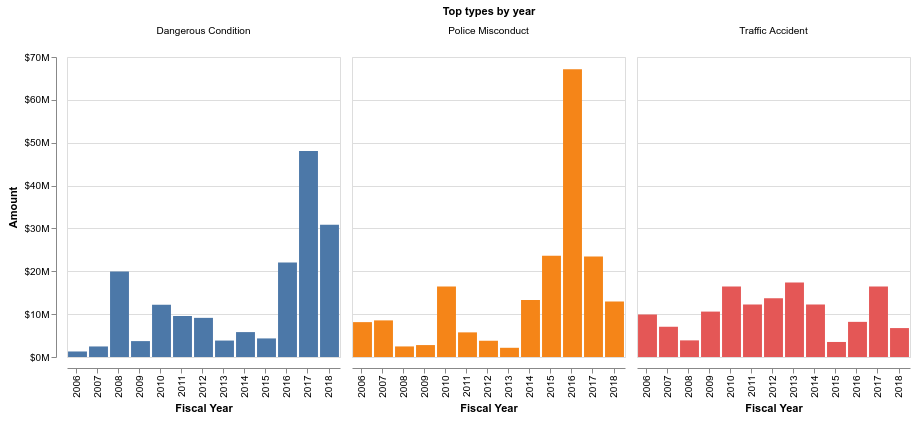

In [143]:
alt.Chart(top_type_annual_totals).mark_bar().encode(
    x=alt.X("fiscal_year:O", axis=alt.Axis(title="Fiscal Year")),
    y=alt.Y("amount:Q", axis=alt.Axis(title="Amount", format="$s")),
    color=alt.Color("latimes_type:N", legend=None),
    column=alt.Column("latimes_type:N", title="Top types by year"),
)

### How many million-dollar cases have there been?

In [144]:
over1mill_df = df[df.amount >= 1000000]

In [145]:
over1mill_annual_counts = over1mill_df.groupby("fiscal_year").agg(dict(
    number="count"
)).reset_index().set_index("fiscal_year")

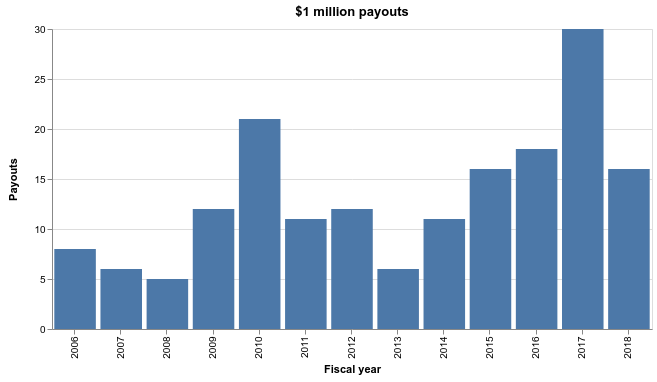

In [146]:
alt.Chart(over1mill_annual_counts.reset_index(), title="$1 million payouts").mark_bar().encode(
    x=alt.X("fiscal_year:O", axis=alt.Axis(title="Fiscal year")),
    y=alt.Y("number:Q", axis=alt.Axis(title="Payouts"))
).properties(width=600)

In [147]:
over1mill_annual_counts

,number
fiscal_year,
2006,8
2007,6
2008,5
2009,12
2010,21
2011,11
2012,12
2013,6
2014,11


### Adjust for inflation

In an interview, City Attorney Mike Feuer raised the possibility that the increase would be less significant if totals were adjusted for inflation. Let's check it out.

In [148]:
df['amount_2017'] = df.apply(lambda x: cpi.inflate(x.amount, x.fiscal_year) if x.fiscal_year < 2018 else x.amount, axis=1)

In [149]:
annual_adjusted_totals = df.groupby("fiscal_year").agg(dict(
    amount_2017="sum"
)).reset_index().set_index("fiscal_year")

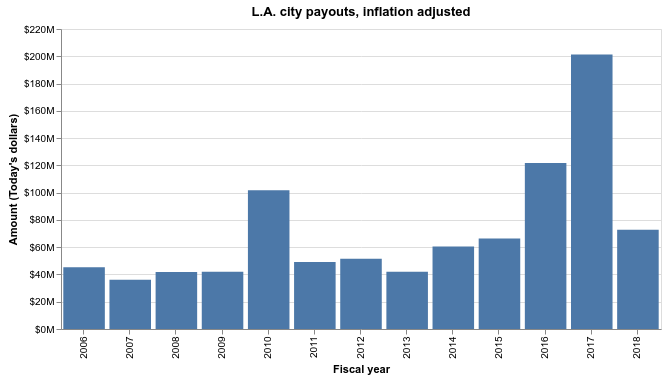

In [150]:
alt.Chart(annual_adjusted_totals.reset_index(), title="L.A. city payouts, inflation adjusted").mark_bar().encode(
    x=alt.X("fiscal_year:O", axis=alt.Axis(title="Fiscal year")),
    y=alt.Y("amount_2017:Q", axis=alt.Axis(title="Amount (Today's dollars)", format="$s")),
).properties(width=600)

In [151]:
"After adjusting for inflation, the peak year was {:.1f} times more than a decade before.".format(
    annual_adjusted_totals.at[2017, "amount_2017"] / annual_adjusted_totals.at[2007, "amount_2017"]
)

'After adjusting for inflation, the peak year was 5.6 times more than a decade before.'

In [152]:
annual_adjusted_totals

,amount_2017
fiscal_year,
2006,"45,238,894.90"
2007,"36,167,429.87"
2008,"41,711,756.74"
2009,"41,989,677.43"
2010,"101,773,392.12"
2011,"49,055,088.56"
2012,"51,564,138.39"
2013,"41,980,505.68"
2014,"60,411,862.62"
